In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from timeit import time
from shape import Shape, Block
from shape_boat import ShapeBoat, ShapeBoat_spline
from shapeshift_trajectory import shapeshift_trajectory, write_results, experiments, print_results_tables


## 1. Composing Shapes from Blocks

In [2]:
s = .90625

shape_1a = Shape([Block(0,0,scale=s)])
shape_1b = Shape([Block(0,0,90,scale=s)])
shape_2a = Shape([Block(-.5,0,scale=s),    Block(.5,0,scale=s)])
shape_2b = Shape([Block(0,0.25,scale=s),   Block(0,-0.25,scale=s)])
shape_2c = Shape([Block(-.25,0,90,scale=s),Block(0.25,0,90,scale=s)])
shape_2d = Shape([Block(0,-.5,90,scale=s) ,Block(0,.5,90,scale=s)])
shape_3a = Shape([Block(-.5,0,scale=s),    Block(.5,0,scale=s),   Block(-1.25,0.25,90,scale=s)])
shape_3b = Shape([Block(-.5,0,scale=s),    Block(.5,0,0,scale=s), Block(-.5,0.5,scale=s)])
shape_3c = Shape([Block(0,0,scale=s),      Block(-1,0,scale=s),   Block(1,0,scale=s)])
shape_4a = Shape([Block(-.5,0,scale=s),    Block(.5,0,scale=s),   Block(-1.25,0.25,90,scale=s),Block(1.25,0.25,90,scale=s)])
shape_4b = Shape([Block(-.5,-.25,scale=s), Block(-.5,.25,scale=s),Block(.5,-.25,scale=s),      Block(.5,.25,scale=s)])
shape_6a = Shape([Block(0,0,scale=s),      Block(1.,0,scale=s),   Block(0,0.5,scale=s),        Block(-1.,0.5,scale=s),Block(1.,0.5,scale=s),Block(1.,-.5,scale=s)])

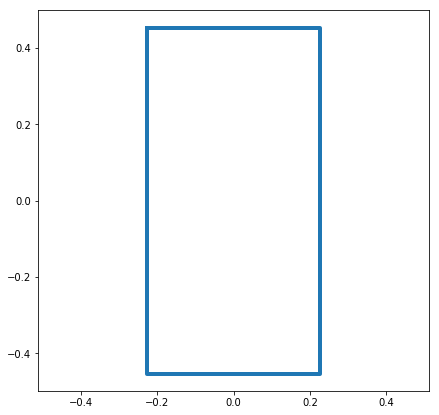

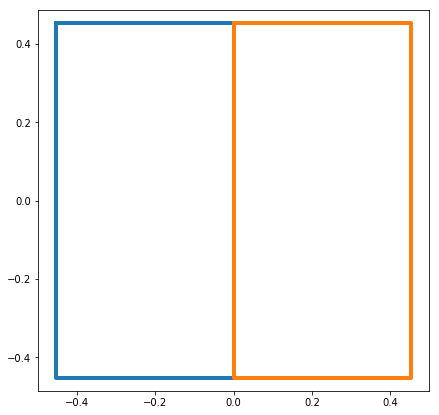

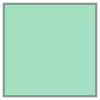

In [3]:
moving_shape=shape_1b
obstacle_shape=shape_2c

moving_shape.plot(union=False)
obstacle_shape.plot(union=False)
from shapely import ops, geometry
obstacle_shape.polygon.simplify(0.2, preserve_topology=False)


### Partitioning of convex hulls around shape

In [4]:
msums, hulls = obstacle_shape.c_space_rotate(moving_shape)
#plot_hulls(hulls, text=False)

### C-Space of a given obstacle b

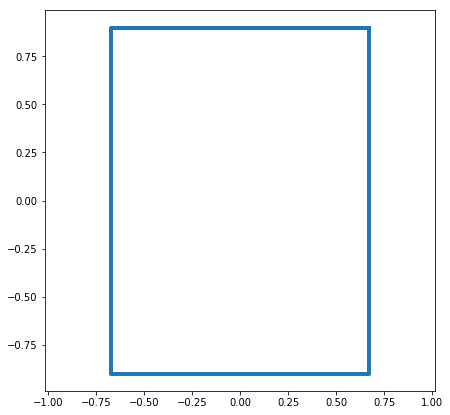

In [5]:
moving_shape.plot_polygons([msums.values()[3]])

### Finding Convex Hull of C-Space

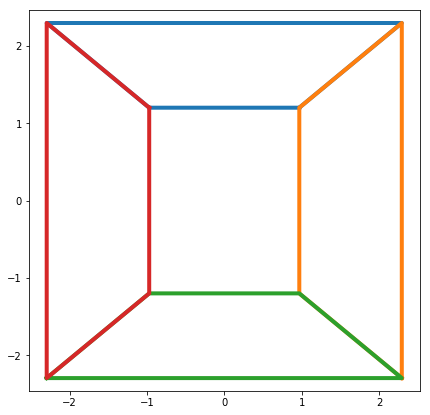

In [6]:
moving_shape.plot_polygons(hulls.values()[3])

## 2. Trajectory Planning

In [9]:
tests = {'1_line_to_L':         (shape_1a, shape_2a, (s*-1.5, s*0.,     0.),  (s*-1,    s*.5,    0.)),  \
         '2_T_to_block':        (shape_1a, shape_3b, (s*-1.5, s*0.,     0.),  (s*.5,    s*.5,    0.)),  \
         '3_line_to_block':     (shape_2a, shape_2a, (s*-2.,  s*0.,     0.),  (s*0.,    s*.5,    0.)),  \
         '4_line_to_L_2':       (shape_2a, shape_2a, (s*-2.,  s*0.,     0.),  (s*-1.25, s*.75,  90.)),  \
         '5_U_to_block':        (shape_3a, shape_3a, (s*2.5,  s*0.,     0.),  (s*0.,    s*.5,  180.)),  \
         '6_line_to_block_2':   (shape_4b, shape_4b, (s*-2.,  s*0.,     0.),  (s*0.,    s*1.,    0.)),  \
         '7_triangle_to_block': (shape_6a, shape_6a, (s*0.,   s*-.5, 180.),  (s*0.,    s*1.5, 180.)),  \
         '8_past':              (shape_1a, shape_4a, (s*-5.,  s*0.,     0.),  (s*5.,    s*0.,    0.)),  \
         '9_shinkyu1':          (shape_1b, shape_2c, (s*-.75, s*0.,     0.),  (s*-.25,  s*1.,    0.)),  \
         '10_shinkyu2':         (shape_1b, shape_2c, (s*-.75, s*0.,     0.),  (s*0.,    s*.75,   90)),  \
         '11_shinkyu3-1':       (shape_2c, shape_1b, (s*-.75, s*0.,     0.),  (s*0.,    s*1.,    0.)),  \
         '12_shinkyu3-2':       (shape_1b, shape_2d, (s*-.75, s*0.5,    0.),  (s*0.,    s*1.5,   0.))
        }

### MIQP - b-splines

SETTING ENDPOINTS
Calculated C-Space: 0.867580 seconds
Set up graph: 0.501685 seconds
finding_vertex POINT (0 -0.453125) 180.0
finding_vertex POINT (0 1.359375) 180.0
found path endpoint hulls 29 33


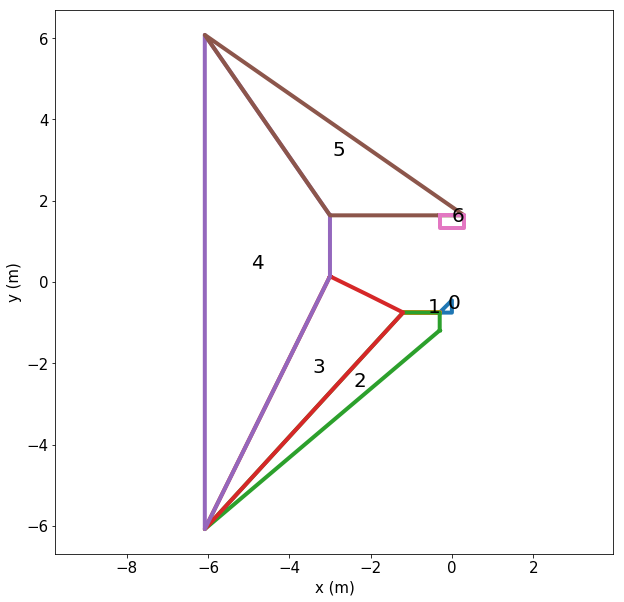

INITIALIZED ShapeBoat_spline 
boats_S:(1, 12, 6), boats_U:(1, 11, 4)
Number of decision vars 193
0.005077 seconds
ADDING COSTS
Number of costs 13
0.015325 seconds
ADDING CONSTRAINTS
None
Number of constraints 1254
0.374817 seconds
PLANNING
SolutionResult.kSolutionFound
Solver: Mosek
0.192068 seconds

SETTING ENDPOINTS
Calculated C-Space: 0.903518 seconds
Set up graph: 0.544610 seconds
finding_vertex POINT (0 -0.453125) 180.0
finding_vertex POINT (0 1.359375) 180.0
found path endpoint hulls 29 33


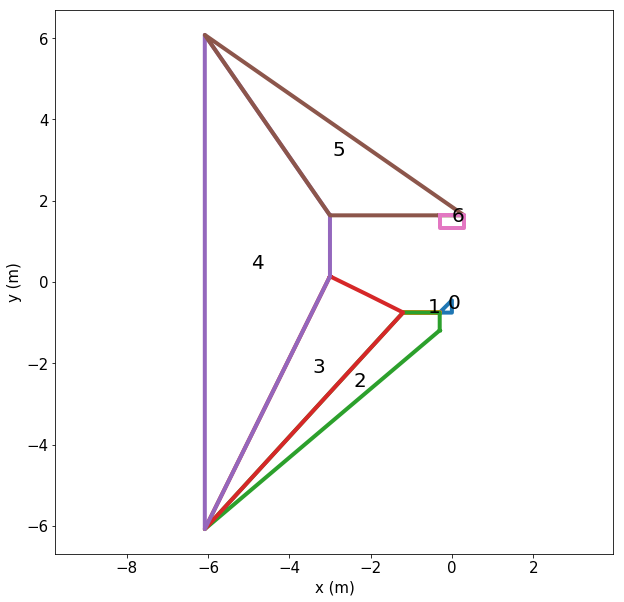

INITIALIZED ShapeBoat_spline 
boats_S:(1, 12, 6), boats_U:(1, 11, 4)
Number of decision vars 116
0.006712 seconds
ADDING COSTS
Number of costs 12
0.014324 seconds
ADDING CONSTRAINTS
[2, 5]
Number of constraints 50
0.088973 seconds
PLANNING
SolutionResult.kSolutionFound
Solver: SNOPT
0.051613 seconds

Time Scaling target: 1.000000, result: 1.000000
Time Scaling target: 11.170107, result: 11.200000


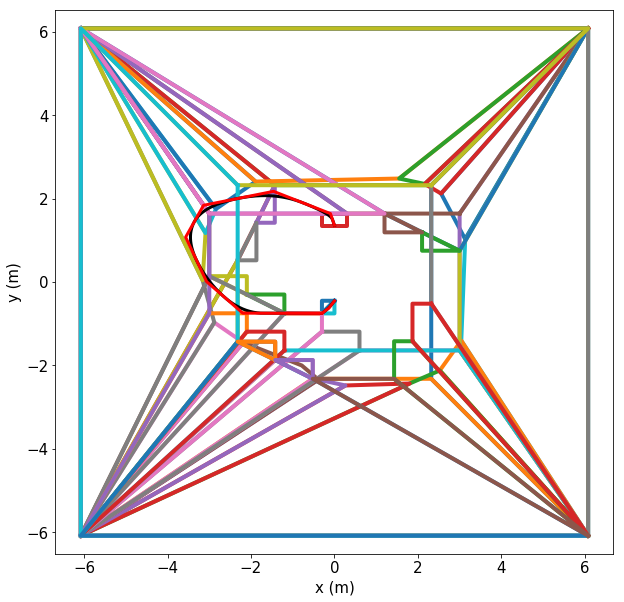

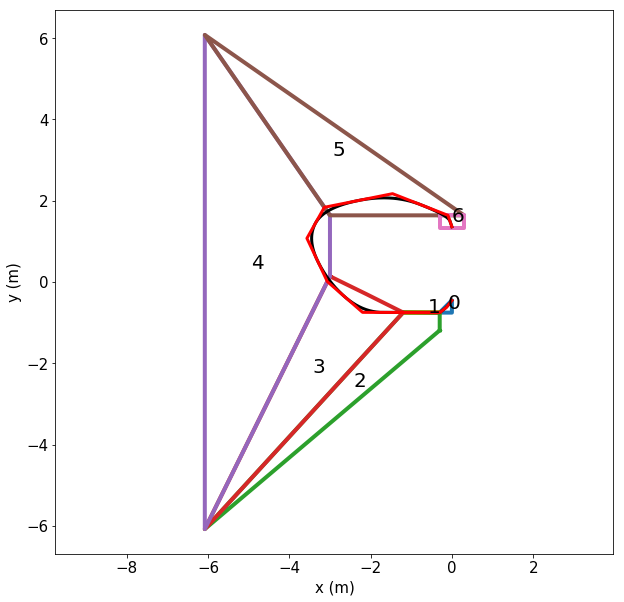

In [10]:
test = '7_triangle_to_block'

x = time.time()
experiment = shapeshift_trajectory(*tests[test], N=11, boat_type=ShapeBoat_spline, boat_type_init=ShapeBoat_spline)
#print experiment['S'].shape, experiment['U'].shape
np.savetxt("shapeshifting_test.txt", np.hstack((experiment['S'][0,:,:],experiment['U'][0,:,:])), delimiter=",")

### Show polytope graph from plan

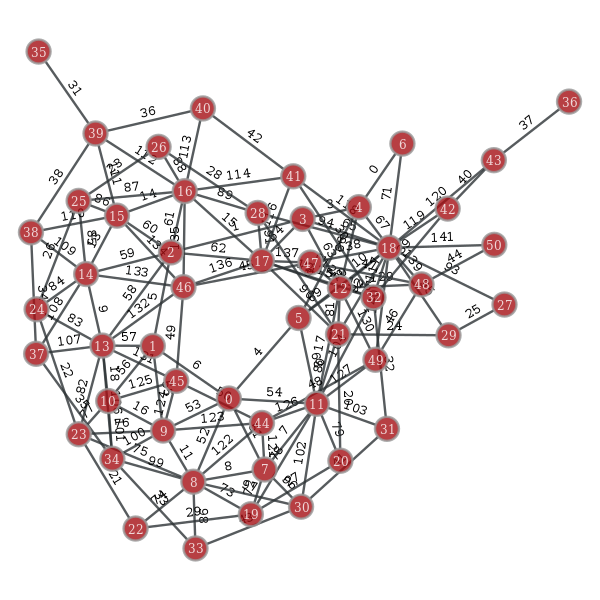

In [17]:
experiment['boat'].g.draw_graph()

## 3. Running Experiments

In [18]:
boats = {'line no-init':(None, ShapeBoat),
         'spline no-init':(None, ShapeBoat_spline),
         'spline init':(ShapeBoat_spline, ShapeBoat_spline)
        }

results = experiments(tests, boats)

SETTING ENDPOINTS
Calculated C-Space: 0.353948 seconds
Set up graph: 0.205065 seconds
finding_vertex POINT (-5 0) 0.0
finding_vertex POINT (5 0) 0.0
found path endpoint hulls None None


AssertionError: 

In [10]:
table = print_results_tables(results)

line no-init
<type 'list'>
experiment           solve_time_init      solve_time_final    solve_time    pos_cost_avg    ang_cost_avg
-------------------  -----------------  ------------------  ------------  --------------  --------------
10_shinkyu2                                          0.141         0.141           2.011           9.744
11_shinkyu3-1                                        0.135         0.135           1.831           0.000
12_shinkyu3-2                                        0.105         0.105           1.500           0.000
1_line_to_L                                          0.120         0.120           1.008           0.000
2_T_to_block                                         0.132         0.132           9.224           0.000
3_line_to_block                                      0.126         0.126           3.272           0.000
4_line_to_L_2                                        0.120         0.120           1.596           9.744
5_U_to_block                

In [11]:
#print in Banti Thesis Format
print_results_tables(results, latex=True)

line no-init
<type 'list'>
experiment             solve_time_init    solve_time_final    solve_time        pos_cost_avg    ang_cost_avg
---------------------  -----------------  ------------------  ----------------  --------------  --------------
& 10 shinkyu2          & -                & 0.140             & \textbf{0.141}  & 2.010         & 9.740 \\
& 11 shinkyu3-1        & -                & 0.140             & \textbf{0.135}  & 1.830         & 0.000 \\
& 12 shinkyu3-2        & -                & 0.110             & \textbf{0.105}  & 1.500         & 0.000 \\
& 1 line to L          & -                & 0.120             & \textbf{0.120}  & 1.010         & 0.000 \\
& 2 T to block         & -                & 0.130             & \textbf{0.132}  & 9.220         & 0.000 \\
& 3 line to block      & -                & 0.130             & \textbf{0.126}  & 3.270         & 0.000 \\
& 4 line to L 2        & -                & 0.120             & \textbf{0.120}  & 1.600         & 9.740 \\
& 5 

In [72]:
write_results(results, 'result_slow')

NameError: name 'results' is not defined